In [1]:
import numpy as np
from numpy.fft import fft, fftshift
from scipy.io import loadmat, savemat, whosmat
import matplotlib.pyplot as plt
from matplotlib import rc
from pprint import pprint  # Pretty Print
from scipy.signal import find_peaks, butter, lfilter


In [2]:
# Plot Settings
rc('font', **{'size': 18})
plt.close('all')
plt.ion()


In [3]:
# Carregando o sinal do arquivo .mat

mat = loadmat('Subject14.mat')
fs = 256
raw_ppg = mat['Subject14'].astype(np.float)
#raw_ppg = np.asarray(mat, dtype = float)
red = raw_ppg[:,7] #channel B
ir = raw_ppg[:,8] #channel B
spo2 = raw_ppg[:,9]

redppg = red[fs:-fs]
irppg = ir[fs:-fs]
t = np.linspace(0, len(redppg)/fs, len(redppg))
print(len(t))

907008


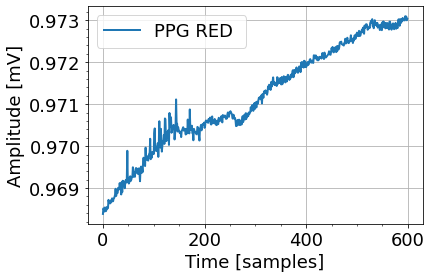

In [5]:
# Plotando um trecho do sinal

Tppg = 100
fig, ax = plt.subplots()
plt.plot(redppg[25000:Tppg * fs], linewidth=2, label='PPG RED ')
plt.ylabel('Amplitude [mV]')
plt.xlabel('Time [samples]')
plt.legend()
plt.grid()


/home/manuella/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


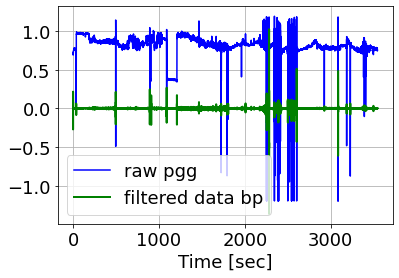

In [8]:
#Filtrando o sinal PPG

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# LOWPASS FILTER
cutoff_lp = 8  # desired cutoff frequency of the filter, Hz

red_lp = butter_lowpass_filter(redppg, cutoff_lp, fs, order=6)
ir_lp = butter_lowpass_filter(irppg, cutoff_lp, fs, order=6)


#DC SIGNAL
cutoff_dc = 0.4
red_dc = butter_lowpass_filter(red_lp, cutoff_dc, fs, order=6)
ir_dc =  butter_lowpass_filter(ir_lp, cutoff_dc, fs, order=6)


# BANDPASS FILTER
lowcut = 2
highcut = 10

red_bp = butter_bandpass_filter(red_lp, lowcut, highcut, fs, order=6)
ir_bp = butter_bandpass_filter(ir_lp, lowcut, highcut, fs, order=6)


plt.plot(t,redppg, 'b-', label='raw pgg')
# plt.plot(t,red_dc, 'b-', label='dc pgg')
plt.plot(t,red_bp, 'g-', linewidth=2, label='filtered data bp')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.show()


10
0.2860908165697682
8
2


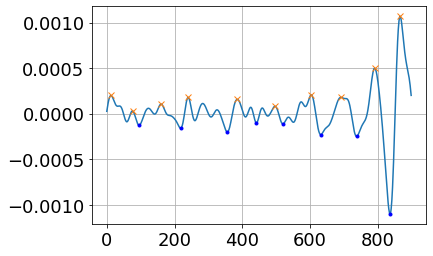

In [16]:
#Picos e Vales
x = red_bp[200000:201000]

#Threshold value (for height of peaks and valleys)
thresh = 0.12 * (abs(min(red_bp)) + abs(max(red_bp)))
distance = 0.25*fs

# Find indices of peaks
peaks_idx, _ = find_peaks(x, height=(-thresh,thresh), distance=distance)

# Find indices of valleys (from inverting the signal)
valley_idx, _ = find_peaks(-x, height=(-thresh,thresh), distance=distance)#(-(abs(max(x))),-thresh)

#FIX LEN PEAKS AND VALLEYS ?????????????? 

# Plot signal
plt.plot(x)
plt.plot(peaks_idx, x[peaks_idx], "x")
plt.plot(valley_idx, x[valley_idx], 'b.')
plt.grid()

print(len(peaks_idx))
print(thresh)
print(len(valley_idx))
print(len(peaks_idx)-len(valley_idx))
 

In [ ]:
#Segmentar os sinais de PPG em intervalos X

duration=int(windowLen*sampleRate)

n_segms = int(np.ceil(len(signal)/duration)

for i in range(0,len(signal),(duration)):
    temp = [data[i:i+duration]]



In [10]:
#Dividir os sinais de PPG em intervalos de ΔT

# Definir o deltaT
deltaT = round(0.75 * fs) #192

# Recorte do sinal em deltaT
n_win = np.ceil(len(red_bp) / deltaT).astype('int')
pad_length = int(n_win * deltaT - len(red_bp))
red_bp = np.append(red_bp, np.zeros([pad_length]))

# Recorte do sinal em deltaT
# usando ordem F (Matlab/Fortran)
crop_red_ppg = red_bp.reshape((deltaT, -1), order='F')

In [11]:
## Matriz para armazenar PSD de cada janela
psd_ecg = np.zeros(crop_red_ppg.shape)

# PSD
mean_psd = np.zeros([deltaT])

for i in range(n_win):
    col = crop_red_ppg[:, i]
    t_f = fftshift(fft(col, deltaT))
    tf = 10 * np.log10(np.abs(t_f)**2)
    mean_psd += tf
    psd_ecg[:, i] = tf

# Calculamos o valor médio (cortamos as freqs negativas)
mean_psd = fftshift(mean_psd / n_win)
mean_psd = mean_psd[:int(np.floor(len(mean_psd) / 2))]
freqs = np.linspace(0, fs / 2, num=len(mean_psd))


In [12]:
crop_win = deltaT // 2
crop_red_ppg = np.ones([2 * crop_win, len(peaks_idx)])


for n, R in enumerate(peaks_idx):
    crop_red_ppg[:,n] = red_bp[R - crop_win:R + crop_win]  # Recorte
    
    
# Definimos a função que recolhe o valor absoluto da FFT em dB e realiza o fftshift
def spect_vals(s): return 10 * np.log10(np.abs(fftshift(fft(s)))**2)


# # Aplicamos a função ao longo das colunas
# psd_crop_ecg = np.apply_along_axis(spect_vals, 0, crop_red_ppg)
# # Calculamos o valor médio (cortamos as freqs negativas)
# mean_psd_crop_ecg = fftshift(np.mean(psd_crop_ecg, axis=1))
# mean_psd_crop_ecg = mean_psd_crop_ecg[:int(
#     np.floor(len(mean_psd_crop_ecg) / 2))]


ValueError: could not broadcast input array from shape (0) into shape (192)